# Domain wall in a ferromagnetic anisotropic chain

In [2]:
#Qiskit modules
import qiskit
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp




#math modules
import math
# SciPy minimizer routine
from scipy.optimize import minimize

## Anzatz representation

In [67]:
bit_size = 10
# Anzatz assume only unentagled states.
# Since we are trying to get the domain wall we fix the first and last spin states to opposite direcions
def anzatz_qc(theta, bit_size):
    q_r = Q_R(bit_size)
    v_qc = QuantumCircuit(q_r)
    i_theta = 0
    for i in range(1, bit_size - 1):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    v_qc.x(bit_size-1)
    return v_qc

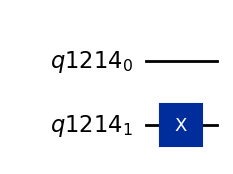

In [68]:
bit_size = 2 
theta = [0, 0, 0, 1, 1, 1]
qc = anzatz_qc(theta, bit_size)
qc.draw('mpl')

## Defining the cost function

In [69]:
# Here we define the Ising anisotropic exchange Hamiltonian
def ising_ham(bit_size):
    interactions = [("ZZ", [0, 1], -1)]
    for i in range(1, bit_size-1):
        interactions.append(("ZZ", [i, i + 1], -1))
 
    hamiltonian = SparsePauliOp.from_sparse_list(interactions, num_qubits=bit_size)
    return hamiltonian

hamiltonian = ising_ham(6)
print(hamiltonian)

SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])


In [70]:
# Here we define the Ising isotropic exchange Hamiltonian
def ising_ham(bit_size):
    interactions = [("ZZ", [0, 1], -1)]
    interactions.append(("YY", [0, 1], -1))
    interactions.append(("XX", [0, 1], -1))
    for i in range(1, bit_size-1):
        interactions.append(("ZZ", [i, i + 1], -1))
        interactions.append(("YY", [i, i + 1], -1))
        interactions.append(("XX", [i, i + 1], -1))
 
    hamiltonian = SparsePauliOp.from_sparse_list(interactions, num_qubits=bit_size)
    return hamiltonian

hamiltonian = ising_ham(6)
print(hamiltonian)

SparsePauliOp(['IIIIZZ', 'IIIIYY', 'IIIIXX', 'IIIZZI', 'IIIYYI', 'IIIXXI', 'IIZZII', 'IIYYII', 'IIXXII', 'IZZIII', 'IYYIII', 'IXXIII', 'ZZIIII', 'YYIIII', 'XXIIII'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j,
 -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])


In [71]:
# defining a cost function
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def estim(theta, bit_size, hamiltonian):
    v_qc = anzatz_qc(theta, bit_size)
    estimator = StatevectorEstimator()
    job = estimator.run([(v_qc, hamiltonian)])
    estimator_expvals = job.result()[0].data.evs
    #print 
    #print('Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals

theta = [0] * 18
estim(theta, 6, hamiltonian)

array(-3.)

In [72]:
#Run COBYLA optimizer
bit_size = 6
#Hamiltonian creation
hamiltonian = ising_ham(bit_size)

#Cost history initialization
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

import random
num = random.random()
#print(num)

#initialize the state
x0 = []
for i in range((bit_size-2) * 3):
    x0.append(random.random())

print(x0)
#Optimization
res = minimize(
        estim,
        x0,
        args=(bit_size , hamiltonian),
        method="cobyla",
    )

[0.3084917338304167, 0.9942648449211856, 0.9486221690847025, 0.18095342760111044, 0.793344541554235, 0.7266859915971939, 0.3799039985638618, 0.1727471319731969, 0.9636992005180288, 0.059117144547004674, 0.05976930840119343, 0.15677601959002396]


In [73]:
res


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.045084947880312
       x: [ 1.362e-01  3.203e-01  4.087e-01  6.665e-01  6.969e-01
            4.068e-01  4.335e-01  5.894e-01  1.429e+00  1.001e+00
            6.158e-01  1.501e+00]
    nfev: 255
   maxcv: 0.0

## Domain wall expected from theory

In [74]:
# Domain wall expected from theory
for i in range(1, bit_size - 1):
    x0[3 * (i - 1)] = math.pi/5 * i
    x0[3 * (i - 1) + 1] = 0
    x0[3 * (i - 1) + 2] = 0

x0

[0.6283185307179586,
 0,
 0,
 1.2566370614359172,
 0,
 0,
 1.8849555921538759,
 0,
 0,
 2.5132741228718345,
 0,
 0]

In [75]:
estim(x0, bit_size, hamiltonian)

array(-4.04508497)

## Optimal (obtained by VQE) state preparation

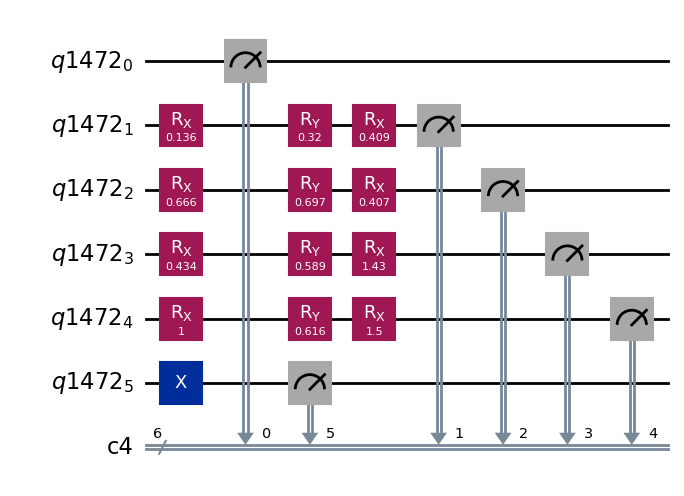

In [76]:
q_r = Q_R(bit_size)
cl_r = C_R(bit_size)
qc_f = QuantumCircuit(q_r,cl_r)
qc_1 = anzatz_qc(res.x, bit_size)
qc_f.append(qc_1, q_r)

for i in range(bit_size):
    qc_f.measure(i,i)

qc_f.decompose().draw('mpl')

In [79]:
shot_num = 4096
simulator = AerSimulator()
qc_tr = transpile(qc_f, simulator)
result = simulator.run(qc_tr,shots = shot_num).result()
counts = result.get_counts(qc_tr)

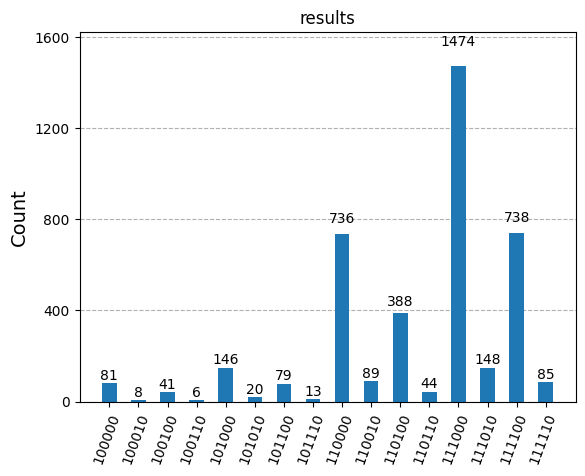

In [80]:
from qiskit.visualization import plot_histogram
plot_histogram(counts, title = 'results')